# 3.2 Process results from global glacier models GloGEM, OGGM and PyGEM

In [1]:
# Import libraries
import os
import re
import numpy as np
import xarray as xr
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns


## GloGEM

### Glacier-wide monthly mass balance

In [2]:
filepath_glo_gw = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Data/ML_model_comparison/GloGEM_glacier_wide/RGI08_glacier-wide/RGI08_glacier-wide/'
filename_glo_gw = 'scandinavia_Balance_mon_r1.dat'

In [3]:
# File structure:
# For each row: 1ID + 12 (monthly) values * num_years. The first year starts with month 10, last year ends with month 9, the first column is glacier ID
# File only contains 1 + 41 column names, representing the identifier and the years.
# Need to create new column names corresponding to year and month

id_col = ['ID']
years = range(1980, 2019)  # 1981 - 2019
initial_months_1980 = ['1979_10', '1979_11', '1979_12']
subsequent_months = [f"{year}_{month:02d}" for year in years for month in range(1, 13)]
final_months_2020 = [f"2019_{month:02d}" for month in range(1, 10)]

# Combine all column names
column_names = id_col + initial_months_1980 + subsequent_months + final_months_2020

# Load data, skip first row with old column names
df = pd.read_csv(filepath_glo_gw + filename_glo_gw, delim_whitespace=True,
                 header=None, names=column_names, index_col=False, skiprows=1)


In [4]:
df

,ID,1979_10,1979_11,1979_12,1980_01,1980_02,1980_03,1980_04,1980_05,1980_06,...,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09
0,3287,0.0000,0.9559,0.6842,0.3142,0.4000,0.2478,0.3683,-0.2213,-0.8148,...,0.6255,0.4889,0.4616,0.7420,-0.2953,-0.3252,-0.7112,-1.0052,-1.4863,-0.9279
1,2665,-0.2588,1.0097,0.7774,0.3603,0.4295,0.2852,0.4059,-0.3080,-0.7726,...,0.7544,0.6131,0.5424,0.8516,-0.3489,-0.3597,-0.7041,-0.9472,-0.9151,-0.9400
2,2669,0.1749,0.7382,0.5573,0.2583,0.3079,0.2045,0.3291,-0.1345,-0.7181,...,0.5588,0.4403,0.4092,0.6155,-0.2181,-0.2066,-0.6371,-0.9221,-0.8808,-0.6952
3,2660,0.1832,0.6302,0.4758,0.2205,0.2629,0.1746,0.2918,-0.0443,-0.6410,...,0.4771,0.3759,0.3494,0.5255,-0.1312,-0.0292,-0.5600,-0.8439,-0.8014,-0.5560
4,336,0.1757,0.8262,0.6238,0.2891,0.3447,0.2288,0.3628,-0.1871,-0.7551,...,0.6246,0.4928,0.4577,0.6889,-0.2593,-0.2797,-0.6741,-0.9596,-1.0686,-0.7885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,2483,0.3128,0.2432,0.3458,0.2675,0.2700,0.1210,0.2393,0.2549,-0.5556,...,0.2513,0.3336,0.3103,0.3644,0.3105,0.2788,-0.3255,-0.6637,-0.6048,-0.3250
3412,2476,0.3199,0.2463,0.3503,0.2709,0.2735,0.1226,0.2433,0.2730,-0.5515,...,0.2546,0.3379,0.3143,0.3691,0.3172,0.3122,-0.3149,-0.6636,-0.6012,-0.3111
3413,3,0.1046,0.1081,0.0910,0.0763,0.0392,0.0660,0.0623,-0.0073,-0.8712,...,0.0607,0.0645,0.1153,0.1060,-0.0012,-0.1885,-0.6308,-1.5916,-1.4324,-0.8067
3414,4,0.1030,0.1074,0.0904,0.0758,0.0390,0.0655,0.0613,-0.0133,-0.8855,...,0.0604,0.0641,0.1146,0.1053,-0.0038,-0.2067,-0.6447,-1.6207,-1.4613,-0.8339


In [155]:
glacier_ids = ['RGI60-08.00434','RGI60-08.00449','RGI60-08.01013','RGI60-08.01026','RGI60-08.01258',
               'RGI60-08.01286','RGI60-08.01484','RGI60-08.01598','RGI60-08.02384','RGI60-08.02650',
               'RGI60-08.02916','RGI60-08.02918','RGI60-08.02920','RGI60-08.02969','RGI60-08.00287',
               'RGI60-08.00295','RGI60-08.00868','RGI60-08.00966','RGI60-08.00987','RGI60-08.01126',
               'RGI60-08.01186','RGI60-08.01217','RGI60-08.01657','RGI60-08.01779','RGI60-08.02017',
               'RGI60-08.02436','RGI60-08.02458','RGI60-08.02643','RGI60-08.02666','RGI60-08.02962',
               'RGI60-08.02963','RGI60-08.02966']

In [177]:
# Extract the IDs from the glacier IDs
glacier_ids_numeric = [int(id_str.split('.')[-1]) for id_str in glacier_ids]

# Filter the DataFrame for the required IDs
filtered_df = df[df['ID'].isin(glacier_ids_numeric)]

# Map numeric IDs to glacier ID strings
id_to_glacier_id_map = {int(id_str.split('.')[-1]): id_str for id_str in glacier_ids}
filtered_df['ID'] = filtered_df['ID'].map(id_to_glacier_id_map)

C:\Users\kasj\AppData\Local\Temp\ipykernel_21960\1391325809.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ID'] = filtered_df['ID'].map(id_to_glacier_id_map)


In [157]:
filtered_df

,ID,1979_10,1979_11,1979_12,1980_01,1980_02,1980_03,1980_04,1980_05,1980_06,...,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09
24,RGI60-08.02650,0.1292,0.6175,0.4662,0.2161,0.2576,0.1710,0.2760,-0.1213,-0.7215,...,0.4671,0.3683,0.3422,0.5149,-0.1973,-0.1554,-0.6370,-0.9339,-1.3845,-0.8716
26,RGI60-08.02666,0.1408,0.6191,0.4674,0.2166,0.2583,0.1715,0.2783,-0.1052,-0.6852,...,0.4684,0.3693,0.3431,0.5163,-0.1810,-0.1287,-0.6042,-0.8887,-1.2651,-0.7623
69,RGI60-08.02966,0.1169,0.5290,0.4012,0.1000,0.1824,0.1168,0.1347,-0.1801,-0.7722,...,0.3058,0.2576,0.2591,0.4413,0.0088,0.1267,-0.6331,-0.9377,-1.0418,-0.6566
72,RGI60-08.02643,0.1266,0.5332,0.4044,0.1008,0.1839,0.1178,0.1390,-0.1560,-0.7508,...,0.3082,0.2596,0.2621,0.4448,0.0207,0.1503,-0.6117,-0.9160,-0.8958,-0.6058
74,RGI60-08.02962,0.1285,0.5306,0.4024,0.1003,0.1830,0.1172,0.1374,-0.1567,-0.7102,...,0.3067,0.2583,0.2604,0.4426,0.0178,0.1481,-0.5809,-0.8639,-0.8276,-0.5317
87,RGI60-08.02916,0.1124,0.4871,0.3698,0.0922,0.1681,0.1077,0.1249,-0.1396,-0.6933,...,0.2817,0.2373,0.2386,0.4066,0.0139,0.1254,-0.5653,-0.8604,-0.8798,-0.5618
89,RGI60-08.02963,0.1268,0.5296,0.4017,0.1002,0.1826,0.1170,0.1363,-0.1589,-0.7098,...,0.3061,0.2579,0.2597,0.4418,0.0152,0.1403,-0.5814,-0.8625,-0.8896,-0.5074
90,RGI60-08.02920,0.1209,0.5471,0.4152,0.1035,0.1887,0.1209,0.1352,-0.2128,-0.7369,...,0.3163,0.2665,0.2666,0.4566,-0.0050,0.1121,-0.6124,-0.8965,-0.9683,-0.6185
92,RGI60-08.02918,0.1436,0.6127,0.4651,0.1160,0.2114,0.1354,0.1509,-0.2165,-0.7465,...,0.3543,0.2985,0.2978,0.5115,-0.0062,0.1179,-0.6219,-0.9039,-0.9833,-0.5607
93,RGI60-08.02969,0.1316,0.5424,0.4115,0.1026,0.1871,0.1198,0.1387,-0.1619,-0.6979,...,0.3135,0.2641,0.2655,0.4526,0.0128,0.1380,-0.5733,-0.8461,-0.8889,-0.4903


In [180]:
df_melted = filtered_df.melt(id_vars=['ID'], var_name='time', value_name='mb_monthly')

# Extract the last 4 digits of the ID and convert column names to datetime
df_melted['ID'] = df_melted['ID'].apply(lambda x: x[-4:])  # Extract last 4 digits of the ID
df_melted['time'] = pd.to_datetime(df_melted['time'].str.replace('_', '-'), format='%Y-%m')

ds = df_melted.set_index(['ID', 'time']).to_xarray()

In [181]:
ds

<xarray.Dataset>
Dimensions:     (ID: 32, time: 480)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1979-10-01 1979-11-01 ... 2019-09-01
Data variables:
    mb_monthly  (ID, time) float64 0.2296 0.2226 0.3388 ... -0.8889 -0.4903

In [182]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds.to_netcdf(filepath_save + 'GloGEM_monthly_mb_glacierwide.nc')

### Glacier-wide seasonal and annual mass balance

In [2]:
filepath_glo_gw = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Data/ML_model_comparison/GloGEM_glacier_wide/RGI08_glacier-wide/RGI08_glacier-wide/'
filename_glo_gw = 'scandinavia_Balance_mon_r1.dat'

In [6]:
# File structure:
# For each row: 1ID + 12 (monthly) values * num_years. The first year starts with month 10, last year ends with month 9, the first column is glacier ID
# File only contains 1 + 41 column names, representing the identifier and the years.
# Need to create new column names corresponding to year and month

id_col = ['ID']
years = range(1980, 2019)  # 1981 - 2019
initial_months_1980 = ['1979_10', '1979_11', '1979_12']
subsequent_months = [f"{year}_{month:02d}" for year in years for month in range(1, 13)]
final_months_2020 = [f"2019_{month:02d}" for month in range(1, 10)]

# Combine all column names
column_names = id_col + initial_months_1980 + subsequent_months + final_months_2020

# Load data, skip first row with old column names
df = pd.read_csv(filepath_glo_gw + filename_glo_gw, delim_whitespace=True,
                 header=None, names=column_names, index_col=False, skiprows=1)


In [7]:
df

,ID,1979_10,1979_11,1979_12,1980_01,1980_02,1980_03,1980_04,1980_05,1980_06,...,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09
0,3287,0.0000,0.9559,0.6842,0.3142,0.4000,0.2478,0.3683,-0.2213,-0.8148,...,0.6255,0.4889,0.4616,0.7420,-0.2953,-0.3252,-0.7112,-1.0052,-1.4863,-0.9279
1,2665,-0.2588,1.0097,0.7774,0.3603,0.4295,0.2852,0.4059,-0.3080,-0.7726,...,0.7544,0.6131,0.5424,0.8516,-0.3489,-0.3597,-0.7041,-0.9472,-0.9151,-0.9400
2,2669,0.1749,0.7382,0.5573,0.2583,0.3079,0.2045,0.3291,-0.1345,-0.7181,...,0.5588,0.4403,0.4092,0.6155,-0.2181,-0.2066,-0.6371,-0.9221,-0.8808,-0.6952
3,2660,0.1832,0.6302,0.4758,0.2205,0.2629,0.1746,0.2918,-0.0443,-0.6410,...,0.4771,0.3759,0.3494,0.5255,-0.1312,-0.0292,-0.5600,-0.8439,-0.8014,-0.5560
4,336,0.1757,0.8262,0.6238,0.2891,0.3447,0.2288,0.3628,-0.1871,-0.7551,...,0.6246,0.4928,0.4577,0.6889,-0.2593,-0.2797,-0.6741,-0.9596,-1.0686,-0.7885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,2483,0.3128,0.2432,0.3458,0.2675,0.2700,0.1210,0.2393,0.2549,-0.5556,...,0.2513,0.3336,0.3103,0.3644,0.3105,0.2788,-0.3255,-0.6637,-0.6048,-0.3250
3412,2476,0.3199,0.2463,0.3503,0.2709,0.2735,0.1226,0.2433,0.2730,-0.5515,...,0.2546,0.3379,0.3143,0.3691,0.3172,0.3122,-0.3149,-0.6636,-0.6012,-0.3111
3413,3,0.1046,0.1081,0.0910,0.0763,0.0392,0.0660,0.0623,-0.0073,-0.8712,...,0.0607,0.0645,0.1153,0.1060,-0.0012,-0.1885,-0.6308,-1.5916,-1.4324,-0.8067
3414,4,0.1030,0.1074,0.0904,0.0758,0.0390,0.0655,0.0613,-0.0133,-0.8855,...,0.0604,0.0641,0.1146,0.1053,-0.0038,-0.2067,-0.6447,-1.6207,-1.4613,-0.8339


In [9]:
glacier_ids = ['RGI60-08.00434','RGI60-08.00449','RGI60-08.01013','RGI60-08.01026','RGI60-08.01258',
               'RGI60-08.01286','RGI60-08.01484','RGI60-08.01598','RGI60-08.02384','RGI60-08.02650',
               'RGI60-08.02916','RGI60-08.02918','RGI60-08.02920','RGI60-08.02969','RGI60-08.00287',
               'RGI60-08.00295','RGI60-08.00868','RGI60-08.00966','RGI60-08.00987','RGI60-08.01126',
               'RGI60-08.01186','RGI60-08.01217','RGI60-08.01657','RGI60-08.01779','RGI60-08.02017',
               'RGI60-08.02436','RGI60-08.02458','RGI60-08.02643','RGI60-08.02666','RGI60-08.02962',
               'RGI60-08.02963','RGI60-08.02966']

In [10]:
# Extract the IDs from the glacier IDs
glacier_ids_numeric = [int(id_str.split('.')[-1]) for id_str in glacier_ids]

# Filter the DataFrame for the required IDs
filtered_df = df[df['ID'].isin(glacier_ids_numeric)]

# Map numeric IDs to glacier ID strings
id_to_glacier_id_map = {int(id_str.split('.')[-1]): id_str for id_str in glacier_ids}
filtered_df['ID'] = filtered_df['ID'].map(id_to_glacier_id_map)


C:\Users\kasj\AppData\Local\Temp\ipykernel_20264\3779674015.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ID'] = filtered_df['ID'].map(id_to_glacier_id_map)


In [11]:
filtered_df.reset_index(inplace=True, drop=True)

In [12]:
filtered_df

,ID,1979_10,1979_11,1979_12,1980_01,1980_02,1980_03,1980_04,1980_05,1980_06,...,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09
0,RGI60-08.02650,0.1292,0.6175,0.4662,0.2161,0.2576,0.1710,0.2760,-0.1213,-0.7215,...,0.4671,0.3683,0.3422,0.5149,-0.1973,-0.1554,-0.6370,-0.9339,-1.3845,-0.8716
1,RGI60-08.02666,0.1408,0.6191,0.4674,0.2166,0.2583,0.1715,0.2783,-0.1052,-0.6852,...,0.4684,0.3693,0.3431,0.5163,-0.1810,-0.1287,-0.6042,-0.8887,-1.2651,-0.7623
2,RGI60-08.02966,0.1169,0.5290,0.4012,0.1000,0.1824,0.1168,0.1347,-0.1801,-0.7722,...,0.3058,0.2576,0.2591,0.4413,0.0088,0.1267,-0.6331,-0.9377,-1.0418,-0.6566
3,RGI60-08.02643,0.1266,0.5332,0.4044,0.1008,0.1839,0.1178,0.1390,-0.1560,-0.7508,...,0.3082,0.2596,0.2621,0.4448,0.0207,0.1503,-0.6117,-0.9160,-0.8958,-0.6058
4,RGI60-08.02962,0.1285,0.5306,0.4024,0.1003,0.1830,0.1172,0.1374,-0.1567,-0.7102,...,0.3067,0.2583,0.2604,0.4426,0.0178,0.1481,-0.5809,-0.8639,-0.8276,-0.5317
5,RGI60-08.02916,0.1124,0.4871,0.3698,0.0922,0.1681,0.1077,0.1249,-0.1396,-0.6933,...,0.2817,0.2373,0.2386,0.4066,0.0139,0.1254,-0.5653,-0.8604,-0.8798,-0.5618
6,RGI60-08.02963,0.1268,0.5296,0.4017,0.1002,0.1826,0.1170,0.1363,-0.1589,-0.7098,...,0.3061,0.2579,0.2597,0.4418,0.0152,0.1403,-0.5814,-0.8625,-0.8896,-0.5074
7,RGI60-08.02920,0.1209,0.5471,0.4152,0.1035,0.1887,0.1209,0.1352,-0.2128,-0.7369,...,0.3163,0.2665,0.2666,0.4566,-0.0050,0.1121,-0.6124,-0.8965,-0.9683,-0.6185
8,RGI60-08.02918,0.1436,0.6127,0.4651,0.1160,0.2114,0.1354,0.1509,-0.2165,-0.7465,...,0.3543,0.2985,0.2978,0.5115,-0.0062,0.1179,-0.6219,-0.9039,-0.9833,-0.5607
9,RGI60-08.02969,0.1316,0.5424,0.4115,0.1026,0.1871,0.1198,0.1387,-0.1619,-0.6979,...,0.3135,0.2641,0.2655,0.4526,0.0128,0.1380,-0.5733,-0.8461,-0.8889,-0.4903


In [13]:
monthly_columns = [col for col in df.columns if col != 'ID']

def extract_year_month(col):
    year, month = col.split('_')
    return int(year), int(month)

# Create a list of (hydro_year, Ba/Bw/Bs type) for each column
handlers = []
for col in monthly_columns:
    year, month = extract_year_month(col)
    if month >= 10:
        hydro_year = year + 1
        season = 'Bw' 
    elif month < 5:
        hydro_year = year
        season = 'Bw' 
    else:
        hydro_year = year
        season = 'Bs' 
    handlers.append((hydro_year, season))

data = []
for idx, row in filtered_df.iterrows():
    id_value = row['ID']
    temp_dict = {}
    temp_dict['ID'] = id_value
    for hydro_year in sorted(set(hyd_year for hyd_year, _ in handlers)):
        temp_dict['Year'] = hydro_year
        Ba = sum(row[col] for col, (yr, _) in zip(monthly_columns, handlers) if yr == hydro_year)
        Bw = sum(row[col] for col, (yr, season) in zip(monthly_columns, handlers) if yr == hydro_year and season == 'Bw')
        Bs = sum(row[col] for col, (yr, season) in zip(monthly_columns, handlers) if yr == hydro_year and season == 'Bs')
        temp_dict['Ba'] = Ba
        temp_dict['Bw'] = Bw
        temp_dict['Bs'] = Bs
        data.append(temp_dict.copy())

result_df = pd.DataFrame(data)

# Remove duplicates that occur because of multiple hydro_year entries for single ID
result_df.drop_duplicates(subset=['ID', 'Year'], inplace=True)

print(result_df)


                  ID  Year      Ba      Bw      Bs
0     RGI60-08.02650  1980 -1.2965  2.1336 -3.4301
1     RGI60-08.02650  1981  1.0601  3.4973 -2.4372
2     RGI60-08.02650  1982  0.3777  2.7355 -2.3578
3     RGI60-08.02650  1983  1.0841  3.2312 -2.1471
4     RGI60-08.02650  1984  1.1511  3.6574 -2.5063
...              ...   ...     ...     ...     ...
1275  RGI60-08.01258  2015 -0.8784  1.4670 -2.3454
1276  RGI60-08.01258  2016 -1.7201  1.4397 -3.1598
1277  RGI60-08.01258  2017 -0.1964  1.6806 -1.8770
1278  RGI60-08.01258  2018 -1.8513  1.3354 -3.1867
1279  RGI60-08.01258  2019  0.0833  1.9309 -1.8476

[1280 rows x 5 columns]


In [14]:
#result_df.to_csv('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/GLOGEM_annual_seasonal_glacier_wide.csv', index=False)

### Elevation-band monthly mass balance

In [65]:
filepath_glo_elevband = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Data/ML_model_comparison/GloGEM_monthly_elevation_bands/mb_elevation_monthly/'
filename_glo_elevband_prefix = 'belev_mon_0'
filename_glo_elevband_suffix = '.dat'


In [66]:
# Folder contains one file per glacier id. Get glacier ids with point mb observations and retrieve only these data.
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)


C:\Users\kasj\AppData\Local\Temp\ipykernel_17644\1641773205.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [67]:
data

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005081,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.000121,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001190,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001945,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.004863,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.009134,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.005585,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759
4168,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.017394,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759
4169,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.007431,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759


In [68]:
# Get list of RGIID using last four digits of the ID
rgi_ids = data['RGIID'].str[-4:].unique()
rgi_ids_list = rgi_ids.tolist()

rgi_ids_list_sorted = sorted(rgi_ids_list, key=lambda x: int(x))

print(rgi_ids_list_sorted)


['0287', '0295', '0434', '0449', '0868', '0966', '0987', '1013', '1026', '1126', '1186', '1217', '1258', '1286', '1484', '1598', '1657', '1779', '2017', '2384', '2436', '2458', '2643', '2650', '2666', '2916', '2918', '2920', '2962', '2963', '2966', '2969']


In [70]:
# Dict to store DataFrames
dfs = {}

# Loop through list of rgiids and read files
for identifier in rgi_ids_list_sorted:

    filename = f'belev_mon_0{identifier}.dat'
    
    df = pd.read_csv(filepath_glo_elevband + filename, delim_whitespace=True, skiprows=2, header=0)
    
    # Replace -99.000 with NaN
    df.replace(-99.000, np.nan, inplace=True)
    
    dfs[identifier] = df

data_arrays = []

# Iterate over dataframes and create dataarray for each
for identifier, df in dfs.items():
    da = xr.DataArray(df.values[:,3:], coords={'time': pd.to_datetime(df[['Year', 'Month']].assign(day=1)),
                                         'elevation': df.columns[3:].astype(int),
                                         'ID': identifier},
                      dims=['time', 'elevation'])
    data_arrays.append(da)

ds = xr.concat(data_arrays, dim='ID')

ds = ds.reindex(elevation=list(np.unique(np.concatenate([da.elevation.values for da in data_arrays]))), fill_value=np.nan)

print(ds)

<xarray.DataArray (ID: 32, time: 480, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

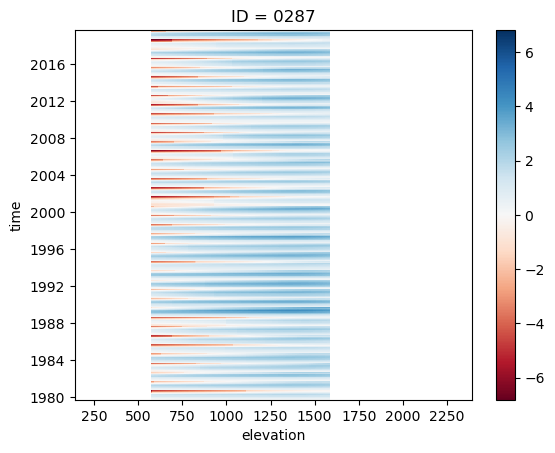

In [71]:
ds[0,:,:].plot(cmap='RdBu')

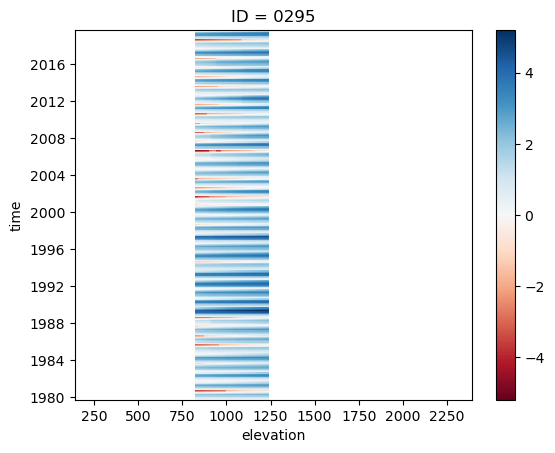

In [72]:
ds[1,:,:].plot(cmap='RdBu')

In [73]:
# Values are cumulative from Oct of each year until september of the following year (cumulative over the hydrological year)
# to get the monthly elevation band value we need to subtract the previous months value (except for october, when a new period starts).
# Calculate the diff along the time dimension to get the monthly values

# Calculate month-to-month differences (monthly mass balance)
diff = ds.diff(dim='time')

diff_padded = xr.concat([ds.isel(time=0).expand_dims('time'), diff], dim='time')

# october should retain original values
is_october = ds['time'].dt.month == 10

ds_monthly_mb_elevband = xr.where(is_october, ds, diff_padded)

# Set nan for non-existing elevation bands
ds_monthly_mb_elevband = ds_monthly_mb_elevband.where(~np.isnan(ds))

# Reorder dimensions
ds_monthly_mb_elevband = ds_monthly_mb_elevband.transpose('ID', 'time', 'elevation')

print(ds_monthly_mb_elevband)


<xarray.DataArray (ID: 32, time: 480, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

In [74]:
# Save monthly elevation-band mass balance as dataset

ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')

filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_monthly_mb_elevband_save.to_netcdf(filepath_save + 'GloGEM_monthly_mb_elev_band.nc')


### Annual mass balance in each elevation band

In [76]:
# Count nan per 12 month window
non_nan_count = ds_monthly_mb_elevband.coarsen(time=12, boundary='trim').count()

# Aggregate mass balance for each year
ds_annual_mb_elevband = ds_monthly_mb_elevband.coarsen(time=12, boundary='trim').sum()

# Insert nan for non-existing elevation bands
ds_annual_mb_elevband = ds_annual_mb_elevband.where(non_nan_count == 12)

# Set hydrological years
hydro_years = pd.date_range(start='1980', end='2020', freq='AS-OCT')

# Set time to hydrological year
ds_annual_mb_elevband['time'] = hydro_years
ds_annual_mb_elevband = ds_annual_mb_elevband.assign_coords(time=hydro_years)

In [77]:
ds_annual_mb_elevband

<xarray.DataArray (ID: 32, time: 40, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

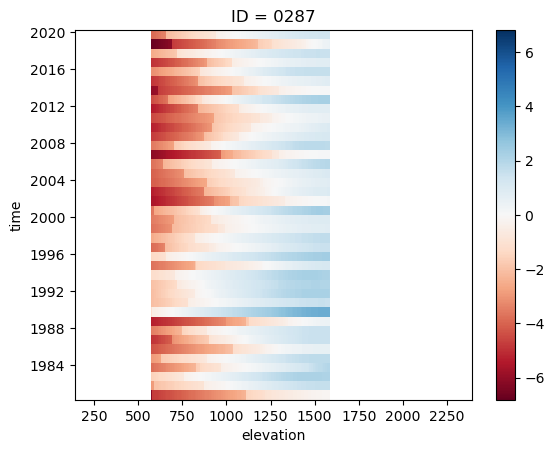

In [78]:
ds_annual_mb_elevband[0,:,:].plot(cmap='RdBu')

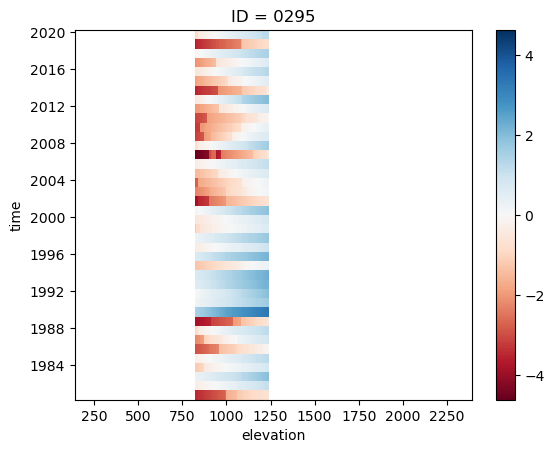

In [79]:
ds_annual_mb_elevband[1,:,:].plot(cmap='RdBu')

### Seasonal mass balance in each elevation band

In [80]:
# Add hydrological year as coordinate in monthly mb dataset
def hydro_year(time):
    year = time.dt.year
    month = time.dt.month
    return year.where(month < 10, year + 1)

ds_monthly_mb_elevband['hyd_year'] = hydro_year(ds_monthly_mb_elevband['time'])

grouped = ds_monthly_mb_elevband.groupby('hyd_year')


In [81]:
def select_sum(group, months):
    selected_group = group.sel(time=group['time.month'].isin(months))
    non_nan_count = selected_group.count(dim='time')
    summed_group = selected_group.sum(dim='time')
    return summed_group.where(non_nan_count >= 1)


In [82]:
# Get winter mass balance in elevation bands

winter_months = [10, 11, 12, 1, 2, 3, 4]

ds_winter_mb_elevband = grouped.map(select_sum, args=(winter_months,))

hyd_yr_dates = pd.date_range('1980-10-01', periods=len(ds_winter_mb_elevband['hyd_year']), freq='AS-OCT')

ds_winter_mb_elevband = ds_winter_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_winter_mb_elevband = ds_winter_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_winter_mb_elevband = ds_winter_mb_elevband.drop_vars('hyd_year')

In [83]:
ds_winter_mb_elevband

<xarray.DataArray (ID: 32, time: 40, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01

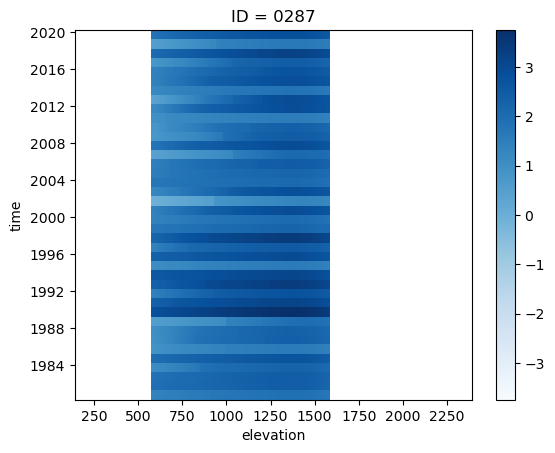

In [84]:
ds_winter_mb_elevband[0,:,:].plot(cmap='Blues')

In [85]:
# Get summer mass balance in elevation bands

summer_months = [5, 6, 7, 8, 9]

ds_summer_mb_elevband = grouped.map(select_sum, args=(summer_months,))

hyd_yr_dates = pd.date_range('1980-10-01', periods=len(ds_summer_mb_elevband['hyd_year']), freq='AS-OCT')

ds_summer_mb_elevband = ds_summer_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_summer_mb_elevband = ds_summer_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_summer_mb_elevband = ds_summer_mb_elevband.drop_vars('hyd_year')

In [86]:
ds_summer_mb_elevband

<xarray.DataArray (ID: 32, time: 40, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01

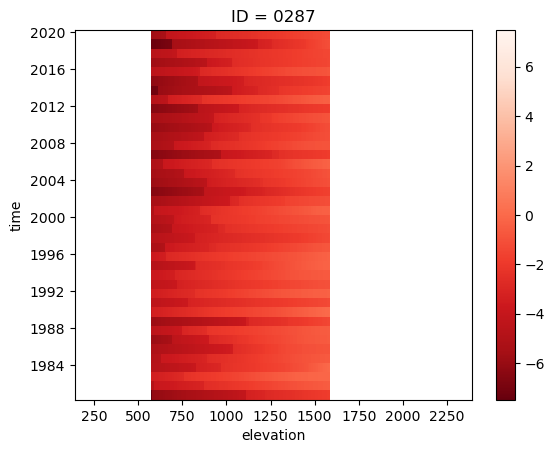

In [88]:
ds_summer_mb_elevband[0,:,:].plot(cmap='Reds_r')

### Combine annual and seasonal elevation-band mass balance in dataset

In [89]:
# Combine the DataArrays into a single dataset
ds_mb_elev_band = xr.Dataset({
    'mb_annual': ds_annual_mb_elevband,  
    'mb_winter': ds_winter_mb_elevband,  
    'mb_summer': ds_summer_mb_elevband
})

ds_mb_elev_band.attrs['Model'] = 'GloGEM'


In [90]:
ds_mb_elev_band

<xarray.Dataset>
Dimensions:    (time: 40, elevation: 225, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Model:    GloGEM

In [91]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_mb_elev_band.to_netcdf(filepath_save + 'GloGEM_annual_seasonal_mb_elev_band.nc')

## OGGM

### Glacier-wide monthly mass balance

In [2]:
filepath_oggm_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/'

# Data structure:
# Dimensions: time: 720 elevation: 98
# Coordinates: time (time) datetime64[ns] 1960-01-01 ... 2019-12-01
#              elevation (elevation) int64 615 625 635 645 ... 1565 1575 1585
# Data variables: massbalance (time, elevation) float64 ...
#                 bin_area (elevation) float64 ...

# Each file has name RGI60-08.0XXXX 
# Attributes massbalance:
#     name:     Monthly mass balance
#     unit:     kg m-2 month-1,

files = [os.path.join(filepath_oggm_elevband, filename) for filename in os.listdir(filepath_oggm_elevband) if filename.startswith('RGI60-08.')]


In [3]:
with xr.open_dataset(files[0]) as ds_out:
    ds = ds_out

ds

<xarray.Dataset>
Dimensions:      (time: 720, elevation: 98)
Coordinates:
  * time         (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * elevation    (elevation) int64 615 625 635 645 655 ... 1555 1565 1575 1585
Data variables:
    massbalance  (time, elevation) float64 ...
    bin_area     (elevation) float64 ...

In [4]:
def process_dataset(ds):
    # Compute total mass balance per elevation band
    mass_balance_weighted = (ds['massbalance'] / rho) * ds['bin_area']

    # Get total glacier area
    total_area = ds['bin_area'].sum(dim='elevation')

    # Get glacier-wide mass balance for the whole glacier
    ds['mb_monthly'] = mass_balance_weighted.sum(dim='elevation') / total_area

    # Oct 1960 through Sept 2019
    ds_sliced = ds.isel(time=slice(9, -3))

    return ds_sliced[['mb_monthly']]  # Ensure we only keep the processed variable

rho = 900 

ds_list = []

for file in files:
    # Extract the last four digits of the RGI ID
    filename = os.path.basename(file)
    rgi_id = filename.split('.')[-2][-4:]
    
    ds = xr.open_dataset(file)

    ds_processed = process_dataset(ds)

    # Assign the RGIID as a coordinate
    ds_processed = ds_processed.assign_coords({'ID': rgi_id})

    ds_list.append(ds_processed)

combined_ds = xr.concat(ds_list, dim='ID')

print(combined_ds)


<xarray.Dataset>
Dimensions:     (ID: 32, time: 708)
Coordinates:
  * time        (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2019-09-01
  * ID          (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_monthly  (ID, time) float64 0.08339 0.009336 0.2221 ... -1.092 -0.08818


In [6]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#combined_ds.to_netcdf(filepath_save + 'OGGM_monthly_mb_glacierwide.nc')

### Glacier-wide annual and seasonal mass balance

In [6]:
filepath_oggm_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/'

# Data structure:
# Dimensions: time: 720 elevation: 98
# Coordinates: time (time) datetime64[ns] 1960-01-01 ... 2019-12-01
#              elevation (elevation) int64 615 625 635 645 ... 1565 1575 1585
# Data variables: massbalance (time, elevation) float64 ...
#                 bin_area (elevation) float64 ...

# Each file has name RGI60-08.0XXXX 
# Attributes massbalance:
#     name:     Monthly mass balance
#     unit:     kg m-2 month-1,

files = [os.path.join(filepath_oggm_elevband, filename) for filename in os.listdir(filepath_oggm_elevband) if filename.startswith('RGI60-08.')]


In [3]:
files

['C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00287.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00295.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00434.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00449.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00868.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00966.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.00987.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.01013.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.01026.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/RGI60-08.01126.nc',
 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocess

In [8]:
def process_dataset(ds):
    # Compute total mass balance per elevation band
    mass_balance_weighted = (ds['massbalance'] / rho) * ds['bin_area']

    # Get total glacier area
    total_area = ds['bin_area'].sum(dim='elevation')

    # Get glacier-wide mass balance for the whole glacier
    ds['massbalance_gw'] = mass_balance_weighted.sum(dim='elevation') / total_area

    # Oct 1960 through Sept 2019
    ds_sliced = ds.isel(time=slice(9, -3))

    def assign_season_and_year(time):
        if time.month >= 10:
            # Annual season and winter season start from October to next September
            return 'annual', time.year + 1, 'winter'
        elif time.month < 5:
            # Summer season from May to September
            return 'annual', time.year, 'winter'
        elif time.month >= 5 and time.month < 10:
            # Summer season from May to September
            return 'annual', time.year, 'summer'
        else:
            # Winter season from October to April
            return 'annual', time.year, None

    time_series = pd.Series(ds_sliced.time.values)
    season_info = time_series.apply(lambda t: pd.Series(assign_season_and_year(pd.Timestamp(t))))
    ds_sliced['season'] = xr.DataArray(season_info[0].values, coords=[ds_sliced.time], name='season')
    ds_sliced['year'] = xr.DataArray(season_info[1].values, coords=[ds_sliced.time], name='year')
    ds_sliced['subseason'] = xr.DataArray(season_info[2].values, coords=[ds_sliced.time], name='subseason')

    massbalance_gw = ds_sliced['massbalance_gw']
    year = ds_sliced['year']
    subseason = ds_sliced['subseason']

    annual_gw = massbalance_gw.groupby(year).sum(dim='time').to_dataframe(name='Ba')

    winter_gw = massbalance_gw.where(subseason == 'winter').groupby(year).sum(dim='time').to_dataframe(name='Bw')

    summer_gw = massbalance_gw.where(subseason == 'summer').groupby(year).sum(dim='time').to_dataframe(name='Bs')

    result_df = annual_gw.join([winter_gw, summer_gw]).reset_index()

    return result_df

rho = 900

df_list = []

for file in files:

    rgi_id = os.path.basename(file).replace('.nc', '')

    with xr.open_dataset(file) as ds_out:
        result_df = process_dataset(ds_out)
        
        result_df['RGIID'] = rgi_id
        
        df_list.append(result_df)

final_df = pd.concat(df_list, ignore_index=True)

print(final_df)

      year        Ba        Bw        Bs           RGIID
0     1961 -1.180584  2.169184 -3.349768  RGI60-08.00287
1     1962 -0.210309  1.555307 -1.765617  RGI60-08.00287
2     1963 -0.527644  3.222508 -3.750152  RGI60-08.00287
3     1964  2.180276  3.583699 -1.403423  RGI60-08.00287
4     1965  0.424091  2.985545 -2.561454  RGI60-08.00287
...    ...       ...       ...       ...             ...
1883  2015  1.344163  3.653286 -2.309123  RGI60-08.02969
1884  2016 -0.570878  2.973452 -3.544329  RGI60-08.02969
1885  2017 -0.472488  2.358645 -2.831133  RGI60-08.02969
1886  2018 -0.988100  2.854169 -3.842269  RGI60-08.02969
1887  2019 -0.587180  2.205174 -2.792353  RGI60-08.02969

[1888 rows x 5 columns]


In [9]:
# Save
#final_df.to_csv('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/OGGM_annual_seasonal_glacier_wide.csv', index=False)

### Elevation-band monthly mass balance

In [203]:
filepath_oggm_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/'

# Data structure:
# Dimensions: time: 720 elevation: 98
# Coordinates: time (time) datetime64[ns] 1960-01-01 ... 2019-12-01
#              elevation (elevation) int64 615 625 635 645 ... 1565 1575 1585
# Data variables: massbalance (time, elevation) float64 ...
#                 bin_area (elevation) float64 ...

# Each file has name RGI60-08.0XXXX 
# Attributes massbalance:
#     name:     Monthly mass balance
#     unit:     kg m-2 month-1,

files = [os.path.join(filepath_oggm_elevband, filename) for filename in os.listdir(filepath_oggm_elevband) if filename.startswith('RGI60-08.')]

rho = 900


In [204]:
massbalance_list = []
all_elevations = set() 

for file in files:
    glacier_id_match = re.search(r'(\d{4})\.nc$', os.path.basename(file))

    if glacier_id_match:
        glacier_id = glacier_id_match.group(1)

        with xr.open_dataset(file) as ds:
            massbalance_da = ds['massbalance']
        
            all_elevations.update(massbalance_da['elevation'].values.tolist())
        
            massbalance_da = massbalance_da.assign_coords(ID=glacier_id)
        
            massbalance_list.append(massbalance_da.expand_dims('ID'))

all_elevations = sorted(list(all_elevations))

ds_monthly_mb_elevband_ = xr.combine_by_coords(massbalance_list, join='outer')

ds_monthly_mb_elevband_ = ds_monthly_mb_elevband_.reindex(elevation=all_elevations, fill_value=np.nan)

ds_monthly_mb_elevband_['massbalance_mwe'] = ds_monthly_mb_elevband_['massbalance']/rho

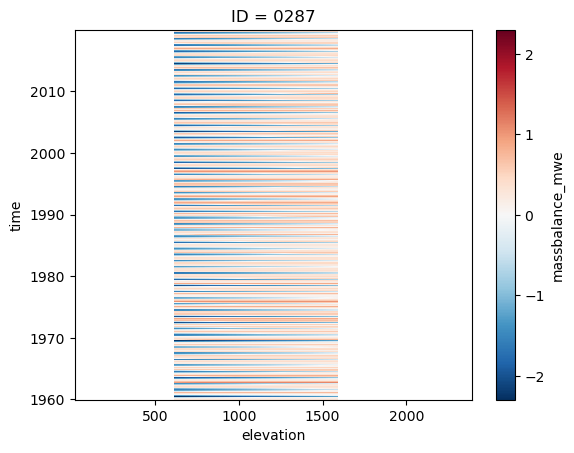

In [205]:
ds_monthly_mb_elevband_.massbalance_mwe[0,:,:].plot()

In [206]:
ds_monthly_mb_elevband_

<xarray.Dataset>
Dimensions:          (time: 720, elevation: 237, ID: 32)
Coordinates:
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * elevation        (elevation) int64 25 35 45 55 65 ... 2355 2365 2375 2385
  * ID               (ID) <U4 '0287' '0295' '0434' ... '2963' '2966' '2969'
Data variables:
    massbalance      (ID, time, elevation) float64 nan nan nan ... nan nan nan
    massbalance_mwe  (ID, time, elevation) float64 nan nan nan ... nan nan nan

In [207]:
# Get dataarray of mass_balance_mwe
ds_monthly_mb_elevband = ds_monthly_mb_elevband_.massbalance_mwe.copy()

In [208]:
ds_monthly_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 720, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

In [209]:
# Save monthly elevation-band mass balance as dataset

ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')

filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_monthly_mb_elevband_save.to_netcdf(filepath_save + 'OGGM_monthly_mb_elev_band.nc')

### Annual mass balance in each elevation band

In [210]:
ds_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

non_nan_count = ds_sliced.coarsen(time=12, boundary='trim').count()

ds_annual_mb_elevband = ds_sliced.coarsen(time=12, boundary='trim').sum()

# Insert nan for non-existing elevation bands
ds_annual_mb_elevband = ds_annual_mb_elevband.where(non_nan_count == 12)

# Set hydrological years
hydro_years = pd.date_range(start='1961', end='2020', freq='AS-OCT')

ds_annual_mb_elevband['time'] = hydro_years
ds_annual_mb_elevband = ds_annual_mb_elevband.assign_coords(time=hydro_years)

In [211]:
ds_annual_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 59, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

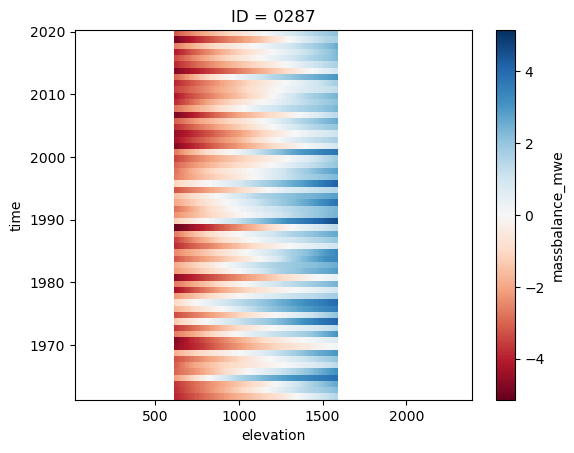

In [212]:
ds_annual_mb_elevband[0,:,:].plot(cmap='RdBu')

### Seasonal mass balance in each elevation band

In [213]:
# Add hydrological year as coordinate
def hydro_year(time):
    year = time.dt.year
    month = time.dt.month
    return year.where(month < 10, year + 1)

ds_monthly_mb_elevband['hyd_year'] = hydro_year(ds_monthly_mb_elevband['time'])

ds_monthly_mb_elevband_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

grouped = ds_monthly_mb_elevband_sliced.groupby('hyd_year')


In [214]:
def select_sum(group, months):
    selected_group = group.sel(time=group['time.month'].isin(months))
    non_nan_count = selected_group.count(dim='time')
    summed_group = selected_group.sum(dim='time')
    return summed_group.where(non_nan_count >= 1)


In [215]:
# Get winter mass balance in elevation bands
winter_months = [10, 11, 12, 1, 2, 3, 4]

ds_winter_mb_elevband = grouped.map(select_sum, args=(winter_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_winter_mb_elevband['hyd_year']), freq='AS-OCT')

ds_winter_mb_elevband = ds_winter_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_winter_mb_elevband = ds_winter_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_winter_mb_elevband = ds_winter_mb_elevband.drop_vars('hyd_year')

In [216]:
ds_winter_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 59, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01

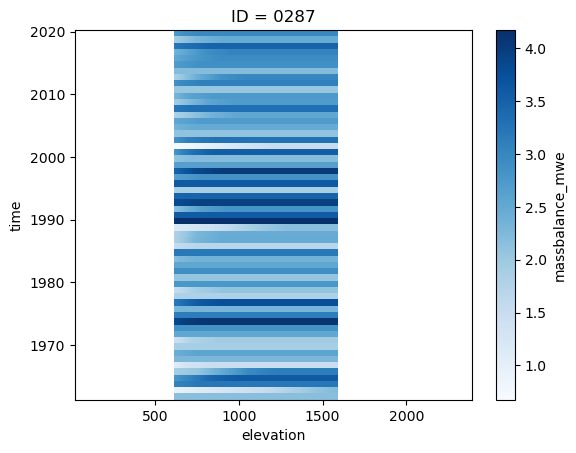

In [217]:
ds_winter_mb_elevband[0,:,:].plot(cmap='Blues')

In [218]:
# Get summer mass balance in elevation bands
summer_months = [5, 6, 7, 8, 9]

ds_summer_mb_elevband = grouped.map(select_sum, args=(summer_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_summer_mb_elevband['hyd_year']), freq='AS-OCT')

ds_summer_mb_elevband = ds_summer_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_summer_mb_elevband = ds_summer_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_summer_mb_elevband = ds_summer_mb_elevband.drop_vars('hyd_year')

In [219]:
ds_summer_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 59, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01

## Combine annual and seasonal elevation-band mb in dataset

In [220]:
# Combine the DataArrays into a single dataset
ds_mb_elev_band = xr.Dataset({
    'mb_annual': ds_annual_mb_elevband,  
    'mb_winter': ds_winter_mb_elevband,  
    'mb_summer': ds_summer_mb_elevband
})

ds_mb_elev_band.attrs['Model'] = 'OGGM'


In [221]:
ds_mb_elev_band

<xarray.Dataset>
Dimensions:    (time: 59, elevation: 237, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Model:    OGGM

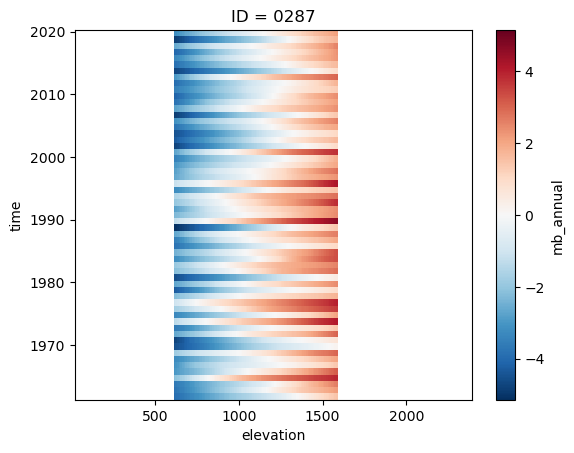

In [222]:
ds_mb_elev_band.mb_annual[0,:,:].plot()

In [223]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_mb_elev_band.to_netcdf(filepath_save + 'OGGM_annual_seasonal_mb_elev_band.nc')

## PyGEM

### Glacier-wide monthly mass balance

In [2]:
import glob

# get list of files containing annual glacier area for region 8
ds_fns = glob.glob('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/glac_massbaltotal_monthly/R08_glac_massbaltotal_monthly_*.nc')

ds_fns_int = []                
for i in ds_fns:
    if 'Batch' in i:
        ds_fns_int.append(int(i.split('-')[-2]))

# sort filenames
if len(ds_fns_int) > 0:
    ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]

for nfn, ds_fn in enumerate(ds_fns):
    if nfn == 0:
        ds = xr.open_dataset(ds_fn)
    else:
        ds_batch = xr.open_dataset(ds_fn)
        ds = xr.concat((ds, ds_batch), dim='glacier')

In [3]:
ds

<xarray.Dataset>
Dimensions:                    (glacier: 3417, time: 756, model: 4)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00001' ... 'RGI60-0...
    Climate_Model              (model) object 'E' 'R' 'A' '5'
    lon                        (glacier) float64 33.83 33.5 33.75 ... 14.3 14.22
    lat                        (glacier) float64 67.93 67.87 ... 66.01 65.92
  * time                       (time) object 1960-01-01 00:00:00 ... 2022-12-...
Dimensions without coordinates: glacier, model
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 nan nan ... 3.39e+07
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [4]:
glacier_ids = ['RGI60-08.00434','RGI60-08.00449','RGI60-08.01013','RGI60-08.01026','RGI60-08.01258',
               'RGI60-08.01286','RGI60-08.01484','RGI60-08.01598','RGI60-08.02384','RGI60-08.02650',
               'RGI60-08.02916','RGI60-08.02918','RGI60-08.02920','RGI60-08.02969','RGI60-08.00287',
               'RGI60-08.00295','RGI60-08.00868','RGI60-08.00966','RGI60-08.00987','RGI60-08.01126',
               'RGI60-08.01186','RGI60-08.01217','RGI60-08.01657','RGI60-08.01779','RGI60-08.02017',
               'RGI60-08.02436','RGI60-08.02458','RGI60-08.02643','RGI60-08.02666','RGI60-08.02962',
               'RGI60-08.02963','RGI60-08.02966']

ds_gl = ds.sel(glacier=ds['RGIId'].isin(glacier_ids))
ds_gl

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 756, model: 4)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    Climate_Model              (model) object 'E' 'R' 'A' '5'
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-01-01 00:00:00 ... 2022-12-...
Dimensions without coordinates: glacier, model
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 1.056e+10 ... 9.28e+09
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [5]:
with xr.open_dataset('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/glac_mass_monthly/R08_glac_area_annual_ERA5_MCMC_ba0_1sets_1960_2022_all.nc') as ds_out:
    ds_area = ds_out

ds_gl_area = ds_area.sel(glacier=ds['RGIId'].isin(glacier_ids))
ds_gl_area

<xarray.Dataset>
Dimensions:           (glacier: 32, time: 64, model: 4)
Coordinates:
    RGIId             (glacier) object ...
    Climate_Model     (model) object ...
    lon               (glacier) float64 ...
    lat               (glacier) float64 ...
  * time              (time) int64 1960 1961 1962 1963 ... 2020 2021 2022 2023
Dimensions without coordinates: glacier, model
Data variables:
    glac_area_annual  (glacier, time) float64 ...
    crs               (glacier) float64 ...
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [6]:
# Slice the dataset from Oct 1960 through Sept 2019
ds_sliced = ds_gl.isel(time=slice(9, -3))
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744, model: 4)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    Climate_Model              (model) object 'E' 'R' 'A' '5'
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier, model
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [7]:
# Remove model dimension
ds_sliced = ds_sliced.mean(dim='model')
ds_gl_area = ds_gl_area.mean(dim='model')

In [8]:
# Add glacier areas to dataset
area_first_time = ds_gl_area['glac_area_annual'].isel(time=0)
area_diff = ds_gl_area['glac_area_annual'] - area_first_time

if not (area_diff == 0).all():
    raise ValueError("glac_area_annual is not constant over time for some glaciers")

unique_areas = ds_gl_area['glac_area_annual'].isel(time=0)
expanded_areas = unique_areas.broadcast_like(ds_sliced)

ds_sliced = ds_sliced.assign(glac_area_annual=expanded_areas)
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
    glac_area_annual           (glacier, time) float64 4.124e+07 ... 2.3e+07

In [9]:
mm_to_m=900 # density of ice
ds_sliced['mb_monthly']=ds_sliced['glac_massbaltotal_monthly']/(ds_sliced['glac_area_annual']*mm_to_m)

In [10]:
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
    glac_area_annual           (glacier, time) float64 4.124e+07 ... 2.3e+07
    mb_monthly                 (glacier, time) float64 0.125 0.0432 ... -0.5978

In [11]:
# Extract last 4 digits of RGIId as string and rename to ID
ds_sliced = ds_sliced.assign_coords(RGIId=[str(x)[-4:] for x in ds_sliced['RGIId'].values])
ds_sliced = ds_sliced.rename({'RGIId': 'ID'})

In [12]:
# Drop variables
ds_sliced = ds_sliced.drop_vars(['lon', 'lat', 'glac_massbaltotal_monthly', 'crs', 'glac_area_annual'])


In [13]:
# Update time format
ds_sliced['time'] = ds_sliced['time'].dt.strftime('%Y-%m-01')

In [14]:
# Re-assign mb_monthly to use ID dimension instead of glacier
ds_monthly = ds_sliced.assign(
    mb_monthly=(('ID', 'time'), ds_sliced['mb_monthly'].values)
)

ds_monthly

<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) object '1960-10-01' '1960-11-01' ... '2022-09-01'
Data variables:
    mb_monthly  (ID, time) float64 0.125 0.0432 0.24 ... -0.9085 -1.079 -0.5978

In [18]:
ds_monthly["time"] = ds_monthly["time"].astype("datetime64[ns]")


In [19]:
ds_monthly


<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2022-09-01
Data variables:
    mb_monthly  (ID, time) float64 0.125 0.0432 0.24 ... -0.9085 -1.079 -0.5978

In [17]:
ds_monthly.isel(ID=0, time=slice(0,12)).sum()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    ID          <U4 '0287'
Data variables:
    mb_monthly  float64 1.59

In [20]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_monthly.to_netcdf(filepath_save + 'PyGEM_monthly_mb_glacierwide.nc')

### Glacier-wide annual and seasonal mass balance

In [37]:
ds_fns = glob.glob('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/glac_massbaltotal_monthly/R08_glac_massbaltotal_monthly_*.nc')

ds_fns_int = []                
for i in ds_fns:
    if 'Batch' in i:
        ds_fns_int.append(int(i.split('-')[-2]))

if len(ds_fns_int) > 0:
    ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]

for nfn, ds_fn in enumerate(ds_fns):
    if nfn == 0:
        ds = xr.open_dataset(ds_fn)
    else:
        ds_batch = xr.open_dataset(ds_fn)
        ds = xr.concat((ds, ds_batch), dim='glacier')

In [38]:
ds

<xarray.Dataset>
Dimensions:                    (glacier: 3417, time: 756, model: 4)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00001' ... 'RGI60-0...
    Climate_Model              (model) object 'E' 'R' 'A' '5'
    lon                        (glacier) float64 33.83 33.5 33.75 ... 14.3 14.22
    lat                        (glacier) float64 67.93 67.87 ... 66.01 65.92
  * time                       (time) object 1960-01-01 00:00:00 ... 2022-12-...
Dimensions without coordinates: glacier, model
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 nan nan ... 3.39e+07
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [39]:
glacier_ids = ['RGI60-08.00434','RGI60-08.00449','RGI60-08.01013','RGI60-08.01026','RGI60-08.01258',
               'RGI60-08.01286','RGI60-08.01484','RGI60-08.01598','RGI60-08.02384','RGI60-08.02650',
               'RGI60-08.02916','RGI60-08.02918','RGI60-08.02920','RGI60-08.02969','RGI60-08.00287',
               'RGI60-08.00295','RGI60-08.00868','RGI60-08.00966','RGI60-08.00987','RGI60-08.01126',
               'RGI60-08.01186','RGI60-08.01217','RGI60-08.01657','RGI60-08.01779','RGI60-08.02017',
               'RGI60-08.02436','RGI60-08.02458','RGI60-08.02643','RGI60-08.02666','RGI60-08.02962',
               'RGI60-08.02963','RGI60-08.02966']

ds_gl = ds.sel(glacier=ds['RGIId'].isin(glacier_ids))
ds_gl

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 756, model: 4)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    Climate_Model              (model) object 'E' 'R' 'A' '5'
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-01-01 00:00:00 ... 2022-12-...
Dimensions without coordinates: glacier, model
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 1.056e+10 ... 9.28e+09
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [44]:
with xr.open_dataset('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/glac_mass_monthly/R08_glac_area_annual_ERA5_MCMC_ba0_1sets_1960_2022_all.nc') as ds_out:
    ds_area = ds_out

ds_gl_area = ds_area.sel(glacier=ds['RGIId'].isin(glacier_ids))


In [45]:
ds_gl_area

<xarray.Dataset>
Dimensions:           (glacier: 32, time: 64, model: 4)
Coordinates:
    RGIId             (glacier) object ...
    Climate_Model     (model) object ...
    lon               (glacier) float64 ...
    lat               (glacier) float64 ...
  * time              (time) int64 1960 1961 1962 1963 ... 2020 2021 2022 2023
Dimensions without coordinates: glacier, model
Data variables:
    glac_area_annual  (glacier, time) float64 ...
    crs               (glacier) float64 ...
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [47]:
# Slice the dataset from Oct 1960 through Sept 2019
ds_sliced = ds_gl.isel(time=slice(9, -3))
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744, model: 4)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    Climate_Model              (model) object 'E' 'R' 'A' '5'
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier, model
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
Attributes:
    Region:       8 - Scandinavia
    source:       PyGEMv0.2.5
    institution:  Carnegie Mellon University
    history:      Created by Brandon S. Tober on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

In [48]:
ds_sliced = ds_sliced.mean(dim='model')
ds_gl_area = ds_gl_area.mean(dim='model')

In [49]:
# Add glacier areas to dataset
area_first_time = ds_gl_area['glac_area_annual'].isel(time=0)
area_diff = ds_gl_area['glac_area_annual'] - area_first_time

if not (area_diff == 0).all():
    raise ValueError("glac_area_annual is not constant over time for some glaciers")

unique_areas = ds_gl_area['glac_area_annual'].isel(time=0)
expanded_areas = unique_areas.broadcast_like(ds_sliced)

ds_sliced = ds_sliced.assign(glac_area_annual=expanded_areas)
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
    glac_area_annual           (glacier, time) float64 4.124e+07 ... 2.3e+07

In [50]:
rho=900
ds_sliced['glac_massbal_monthly']=ds_sliced['glac_massbaltotal_monthly']/(ds_sliced['glac_area_annual']*rho)

In [51]:
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
    glac_area_annual           (glacier, time) float64 4.124e+07 ... 2.3e+07
    glac_massbal_monthly       (glacier, time) float64 0.125 0.0432 ... -0.5978

In [52]:
import cftime

def assign_season_and_year(time):
    if time.month >= 10:
        # Annual season and winter season start from October to next September
        return 'annual', time.year + 1, 'winter'
    elif time.month < 5:
        # Summer season from May to September
        return 'annual', time.year, 'winter'
    elif time.month >= 5 and time.month < 10:
        # Summer season from May to September
        return 'annual', time.year, 'summer'
    else:
        # Winter season from October to April
        return 'annual', time.year, None

time_values = ds_sliced['time'].values

if isinstance(time_values[0], cftime.datetime):
    time_series = [assign_season_and_year(time) for time in time_values]
else:
    time_series = [assign_season_and_year(pd.Timestamp(time)) for time in time_values]

season_info = pd.DataFrame(time_series, columns=['season', 'year', 'subseason'])

ds_sliced['season'] = xr.DataArray(season_info['season'].values, coords=[ds_sliced.time], name='season')
ds_sliced['year'] = xr.DataArray(season_info['year'].values, coords=[ds_sliced.time], name='year')
ds_sliced['subseason'] = xr.DataArray(season_info['subseason'].values, coords=[ds_sliced.time], name='subseason')


In [53]:
ds_sliced

<xarray.Dataset>
Dimensions:                    (glacier: 32, time: 744)
Coordinates:
    RGIId                      (glacier) object 'RGI60-08.00287' ... 'RGI60-0...
    lon                        (glacier) float64 13.99 13.63 ... 6.438 6.362
    lat                        (glacier) float64 66.69 66.45 ... 60.09 59.99
  * time                       (time) object 1960-10-01 00:00:00 ... 2022-09-...
Dimensions without coordinates: glacier
Data variables:
    glac_massbaltotal_monthly  (glacier, time) float64 4.638e+09 ... -1.237e+10
    crs                        (glacier) float64 nan nan nan nan ... nan nan nan
    glac_area_annual           (glacier, time) float64 4.124e+07 ... 2.3e+07
    glac_massbal_monthly       (glacier, time) float64 0.125 0.0432 ... -0.5978
    season                     (time) object 'annual' 'annual' ... 'annual'
    year                       (time) int64 1961 1961 1961 ... 2022 2022 2022
    subseason                  (time) object 'winter' 'winter' ... 'summer'

In [54]:
df = ds_sliced.to_dataframe().reset_index()

In [55]:
df

,glacier,time,glac_massbaltotal_monthly,crs,RGIId,lon,lat,glac_area_annual,glac_massbal_monthly,season,year,subseason
0,0,1960-10-01 00:00:00,4.638406e+09,NaN,RGI60-08.00287,13.994,66.685,41235000.0,0.124986,annual,1961,winter
1,0,1960-11-01 00:00:00,1.603142e+09,NaN,RGI60-08.00287,13.994,66.685,41235000.0,0.043198,annual,1961,winter
2,0,1960-12-01 00:00:00,8.904946e+09,NaN,RGI60-08.00287,13.994,66.685,41235000.0,0.239951,annual,1961,winter
3,0,1961-01-01 00:00:00,1.355010e+10,NaN,RGI60-08.00287,13.994,66.685,41235000.0,0.365119,annual,1961,winter
4,0,1961-02-01 00:00:00,2.773886e+10,NaN,RGI60-08.00287,13.994,66.685,41235000.0,0.747446,annual,1961,winter
...,...,...,...,...,...,...,...,...,...,...,...,...
23803,31,2022-05-01 00:00:00,4.176540e+09,NaN,RGI60-08.02969,6.362,59.989,23000000.0,0.201765,annual,2022,summer
23804,31,2022-06-01 00:00:00,-1.537457e+10,NaN,RGI60-08.02969,6.362,59.989,23000000.0,-0.742733,annual,2022,summer
23805,31,2022-07-01 00:00:00,-1.880516e+10,NaN,RGI60-08.02969,6.362,59.989,23000000.0,-0.908462,annual,2022,summer
23806,31,2022-08-01 00:00:00,-2.233784e+10,NaN,RGI60-08.02969,6.362,59.989,23000000.0,-1.079123,annual,2022,summer


In [57]:
# Aggregate glac_mb_monthly by year, RGIId, and subseason
winter_mb = df[df['subseason'] == 'winter'].groupby(['year', 'RGIId']).agg({'glac_massbal_monthly': 'sum'}).reset_index()
summer_mb = df[df['subseason'] == 'summer'].groupby(['year', 'RGIId']).agg({'glac_massbal_monthly': 'sum'}).reset_index()
annual_mb = df.groupby(['year', 'RGIId']).agg({'glac_massbal_monthly': 'sum'}).reset_index()

winter_mb.rename(columns={'glac_massbal_monthly': 'Bw'}, inplace=True)
summer_mb.rename(columns={'glac_massbal_monthly': 'Bs'}, inplace=True)
annual_mb.rename(columns={'glac_massbal_monthly': 'Ba'}, inplace=True)

df_combined = pd.merge(annual_mb, winter_mb, on=['year', 'RGIId'], how='left')
df_combined = pd.merge(df_combined, summer_mb, on=['year', 'RGIId'], how='left')

df_combined = df_combined[['year', 'RGIId', 'Ba', 'Bw', 'Bs']]
print(df_combined.head())


   year           RGIId        Ba        Bw        Bs
0  1961  RGI60-08.00287  1.590050  2.504335 -0.914285
1  1961  RGI60-08.00295  1.402142  2.998990 -1.596849
2  1961  RGI60-08.00434  1.146692  2.240468 -1.093776
3  1961  RGI60-08.00449  0.620259  1.219500 -0.599242
4  1961  RGI60-08.00868  0.985669  1.172228 -0.186559


In [59]:
df_combined

,year,RGIId,Ba,Bw,Bs
0,1961,RGI60-08.00287,1.590050,2.504335,-0.914285
1,1961,RGI60-08.00295,1.402142,2.998990,-1.596849
2,1961,RGI60-08.00434,1.146692,2.240468,-1.093776
3,1961,RGI60-08.00449,0.620259,1.219500,-0.599242
4,1961,RGI60-08.00868,0.985669,1.172228,-0.186559
...,...,...,...,...,...
1979,2022,RGI60-08.02920,0.234622,3.758431,-3.523809
1980,2022,RGI60-08.02962,0.118508,3.815482,-3.696974
1981,2022,RGI60-08.02963,0.137094,3.666155,-3.529061
1982,2022,RGI60-08.02966,0.357176,3.751575,-3.394399


In [70]:
#df_combined.rename(columns={'Ba_specific':'Ba','Bw_specific':'Bw','Bs_specific':'Bs','RGIId':'RGIID','year':'Year'}, inplace=True)
df_combined.rename(columns={'RGIId':'RGIID','year':'Year'}, inplace=True)
df_combined

,Year,RGIID,Ba,Bw,Bs
0,1961,RGI60-08.00287,1.590050,2.504335,-0.914285
1,1961,RGI60-08.00295,1.402142,2.998990,-1.596849
2,1961,RGI60-08.00434,1.146692,2.240468,-1.093776
3,1961,RGI60-08.00449,0.620259,1.219500,-0.599242
4,1961,RGI60-08.00868,0.985669,1.172228,-0.186559
...,...,...,...,...,...
1979,2022,RGI60-08.02920,0.234622,3.758431,-3.523809
1980,2022,RGI60-08.02962,0.118508,3.815482,-3.696974
1981,2022,RGI60-08.02963,0.137094,3.666155,-3.529061
1982,2022,RGI60-08.02966,0.357176,3.751575,-3.394399


In [71]:
df_combined.to_csv('C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/PYGEM_annual_seasonal_glacier_wide.csv', index=False)

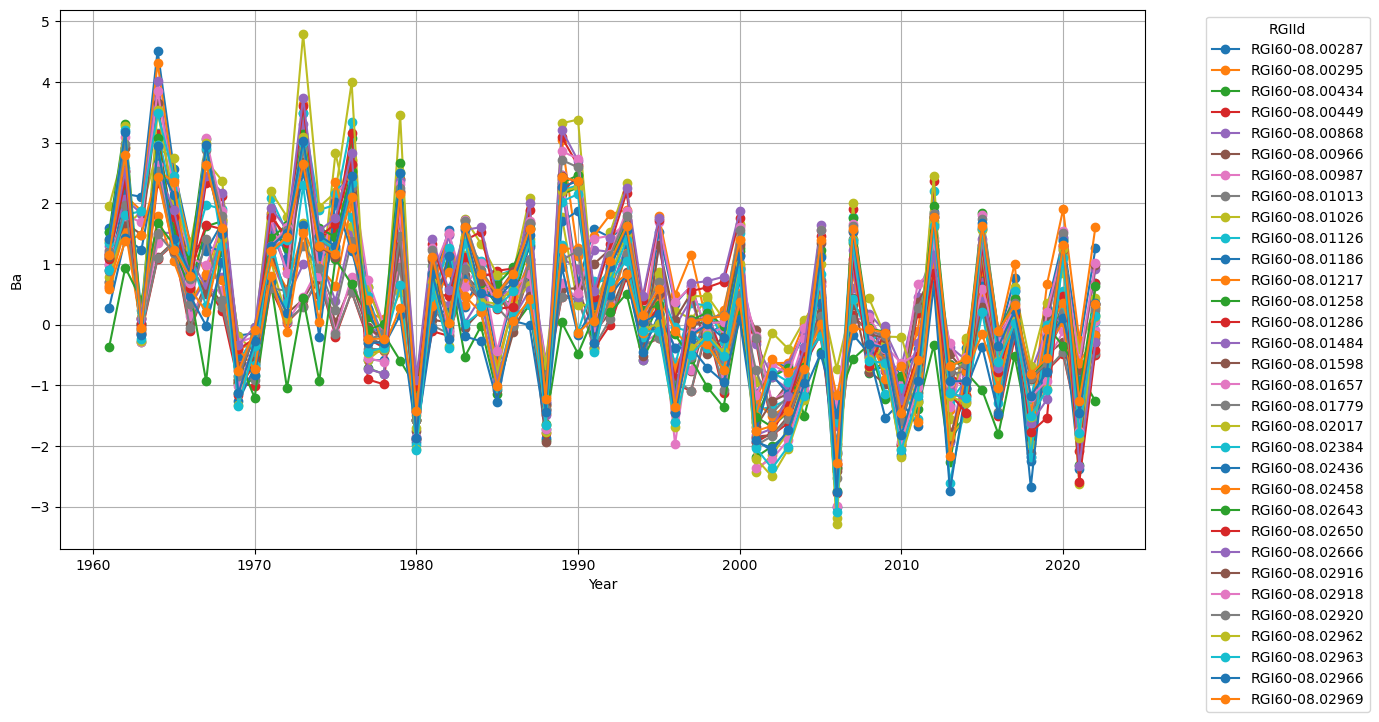

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


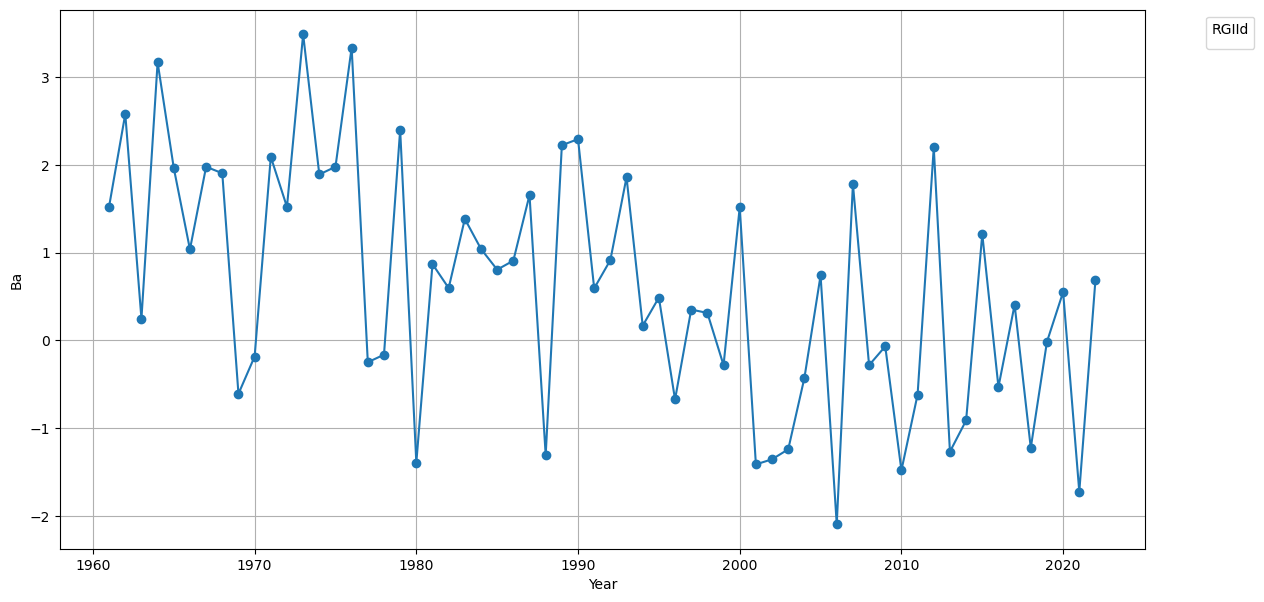

In [72]:
plt.figure(figsize=(14, 7))
for rgi_id in df_combined['RGIID'].unique():
    glacier_data = df_combined[df_combined['RGIID'] == rgi_id]
    plt.plot(glacier_data['Year'], glacier_data['Ba'], marker='o', label=rgi_id)
plt.xlabel('Year')
plt.ylabel('Ba')
plt.legend(title='RGIId', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

nig_data = df_combined[df_combined['RGIID']=='RGI60-08.01126']

plt.figure(figsize=(14, 7))
plt.plot(nig_data['Year'], nig_data['Ba'], marker='o')
plt.xlabel('Year')
plt.ylabel('Ba')
plt.legend(title='RGIID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Elevation-band monthly mass balance

In [144]:
filepath_pygem_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/'

fn = '8.02918_ERA5_MCMC_ba0_1sets_1960_2022_binned.nc'

with xr.open_dataset(filepath_pygem_elevband + fn) as test_out:
    test = test_out

In [145]:
test

<xarray.Dataset>
Dimensions:                  (glac: 1, bin: 68, year: 64, time: 756)
Coordinates:
  * glac                     (glac) int64 972
  * bin                      (bin) int64 0 1 2 3 4 5 6 ... 61 62 63 64 65 66 67
  * year                     (year) int64 1960 1961 1962 1963 ... 2021 2022 2023
  * time                     (time) object 1960-01-01 00:00:00 ... 2022-12-01...
Data variables: (12/14)
    RGIId                    (glac) object ...
    CenLon                   (glac) float64 ...
    CenLat                   (glac) float64 ...
    O1Region                 (glac) int64 ...
    O2Region                 (glac) int64 ...
    Area                     (glac) float64 ...
    ...                       ...
    bin_mass_annual          (glac, bin, year) float64 ...
    bin_thick_annual         (glac, bin, year) float64 ...
    bin_massbalclim_annual   (glac, bin, year) float64 ...
    bin_massbalclim_monthly  (glac, bin, time) float64 ...
    bin_thick_monthly        (glac, bin, time) float64 ...
    bin_mass_monthly         (glac, bin, time) float64 ...
Attributes:
    source:       PyGEMv0.2.5
    institution:  University of Alaska Fairbanks, Fairbanks, AK
    history:      Created by David Rounce (drounce@alaska.edu) on 2024-02-28
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91

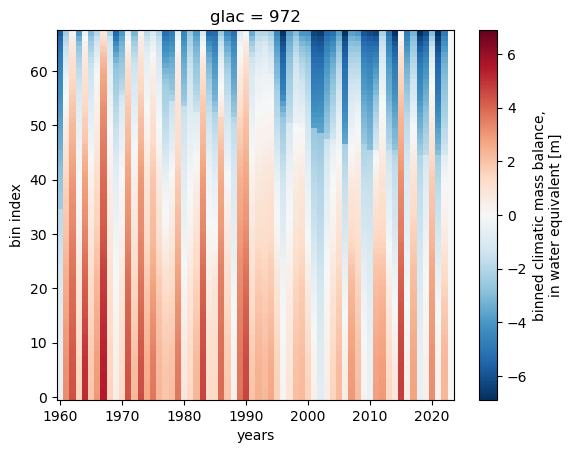

In [187]:
test.bin_massbalclim_annual[0,:,:].plot()

In [188]:
test.bin_distance.values

array([[    0.,   154.,   308.,   462.,   616.,   770.,   924.,  1078.,
         1232.,  1386.,  1540.,  1694.,  1848.,  2002.,  2156.,  2310.,
         2464.,  2618.,  2772.,  2926.,  3080.,  3234.,  3388.,  3542.,
         3696.,  3850.,  4004.,  4158.,  4312.,  4466.,  4620.,  4774.,
         4928.,  5082.,  5236.,  5390.,  5544.,  5698.,  5852.,  6006.,
         6160.,  6314.,  6468.,  6622.,  6776.,  6930.,  7084.,  7238.,
         7392.,  7546.,  7700.,  7854.,  8008.,  8162.,  8316.,  8470.,
         8624.,  8778.,  8932.,  9086.,  9240.,  9394.,  9548.,  9702.,
         9856., 10010., 10164., 10318.]])

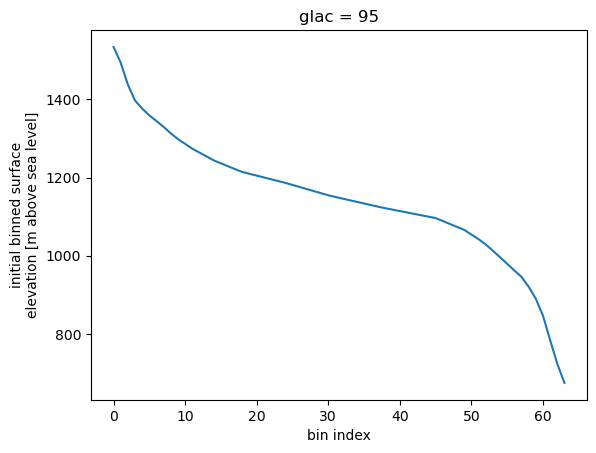

In [102]:
test.bin_surface_h_initial[0,:].plot()

In [150]:
massbal_list = []

for filename in netcdf_files:
    id_match = re.search(r"8\.0(\d{4})_ERA5_MCMC_ba0_1sets_1960_2022_binned\.nc", filename)
    if id_match:
        glacier_id = id_match.group(1)
        ds = xr.open_dataset(os.path.join(filepath_pygem_elevband, filename))
        elevation_rounded = np.round(ds['bin_surface_h_initial'].isel(glac=0).values, decimals=1)
        
        # Replace the 'bin' coordinate with the rounded elevation values
        massbal = ds['bin_massbalclim_monthly'].isel(glac=0).assign_coords(bin=elevation_rounded).rename({'bin': 'elevation'})
        
        time_coords = pd.to_datetime(massbal['time'].dt.strftime('%Y-%m-01'))
        
        # Elevation bins increment by 10m
        elevation_bin_edges = np.arange(
            start=np.floor(elevation_rounded.min() / 10) * 10,
            stop=np.ceil(elevation_rounded.max() / 10) * 10 + 1,
            step=10
            )
 
        elevation_bin_midpoints = (elevation_bin_edges[:-1] + elevation_bin_edges[1:]) / 2
        
        # Get mean of elevation band
        massbal_coarsened = massbal.groupby_bins('elevation', bins=elevation_bin_edges, right=False).mean()

        massbal_expanded = np.expand_dims(massbal_coarsened.values, axis=0)
        
        new_massbal_coarsened = xr.DataArray(
            data=massbal_expanded, 
            coords={'ID': [glacier_id], 'elevation': elevation_bin_midpoints, 'time': time_coords},
            dims=('ID', 'elevation', 'time'),
            name='massbal'
        )
        
        massbal_list.append(new_massbal_coarsened)

concatenated_dataset = xr.concat(massbal_list, dim='ID')

ds_monthly_mb_elevband = concatenated_dataset.transpose('ID', 'time', 'elevation')


In [152]:
ds_monthly_mb_elevband.time

<xarray.DataArray 'time' (time: 756)>
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2022-12-01

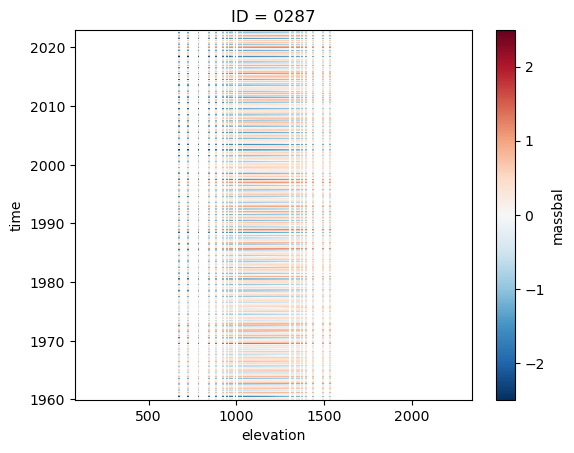

In [151]:
ds_monthly_mb_elevband[0,:,:].plot()

In [153]:
# Save monthly elevation-band mass balance as dataset

ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')

filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

ds_monthly_mb_elevband_save.to_netcdf(filepath_save + 'PyGEM_monthly_mb_elev_band.nc')

### Annual mass balance in each elevation band

In [163]:
ds_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

non_nan_count = ds_sliced.coarsen(time=12, boundary='trim').count()

ds_annual_mb_elevband = ds_sliced.coarsen(time=12, boundary='trim').sum()

ds_annual_mb_elevband = ds_annual_mb_elevband.where(non_nan_count == 12)

hydro_years = pd.date_range(start='1961', end='2023', freq='AS-OCT')

ds_annual_mb_elevband['time'] = hydro_years
ds_annual_mb_elevband = ds_annual_mb_elevband.assign_coords(time=hydro_years)

In [164]:
ds_annual_mb_elevband

<xarray.DataArray 'massbal' (ID: 32, time: 62, elevation: 226)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

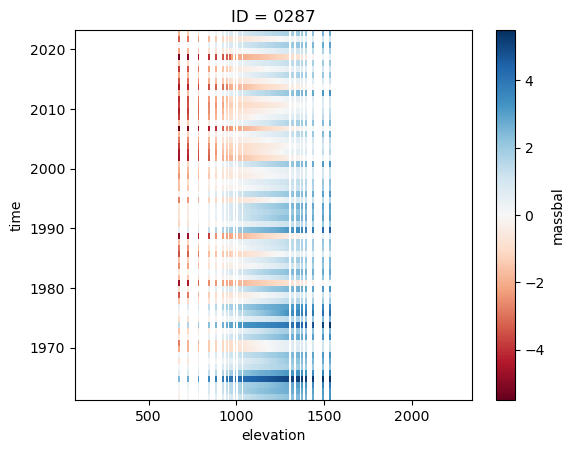

In [166]:
ds_annual_mb_elevband[0,:,:].plot(cmap='RdBu')

### Seasonal mass balance in each elevation band

In [167]:
# Add hydrological year as coord
def hydro_year(time):
    year = time.dt.year
    month = time.dt.month
    return year.where(month < 10, year + 1)

ds_monthly_mb_elevband['hyd_year'] = hydro_year(ds_monthly_mb_elevband['time'])

ds_monthly_mb_elevband_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

grouped = ds_monthly_mb_elevband_sliced.groupby('hyd_year')


In [168]:
def select_sum(group, months):
    selected_group = group.sel(time=group['time.month'].isin(months))
    non_nan_count = selected_group.count(dim='time')
    summed_group = selected_group.sum(dim='time')
    return summed_group.where(non_nan_count >= 1)


In [169]:
# Get winter mass balance in elevation bands
winter_months = [10, 11, 12, 1, 2, 3, 4]

ds_winter_mb_elevband = grouped.map(select_sum, args=(winter_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_winter_mb_elevband['hyd_year']), freq='AS-OCT')

ds_winter_mb_elevband = ds_winter_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_winter_mb_elevband = ds_winter_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_winter_mb_elevband = ds_winter_mb_elevband.drop_vars('hyd_year')

In [170]:
ds_winter_mb_elevband

<xarray.DataArray 'massbal' (ID: 32, time: 62, elevation: 226)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01

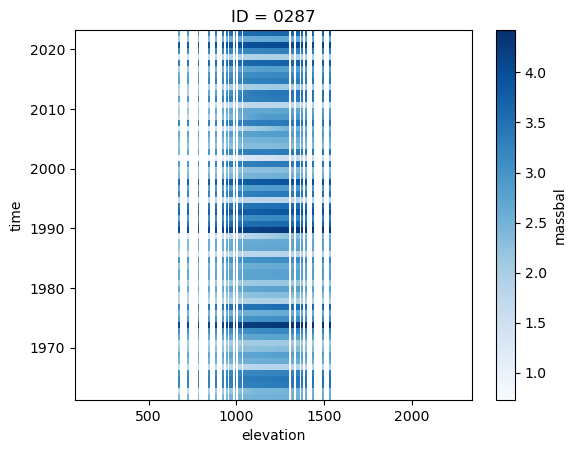

In [171]:
ds_winter_mb_elevband[0,:,:].plot(cmap='Blues')

In [172]:
# Get summer mass balance in elevation bands
summer_months = [5, 6, 7, 8, 9]

ds_summer_mb_elevband = grouped.map(select_sum, args=(summer_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_summer_mb_elevband['hyd_year']), freq='AS-OCT')

ds_summer_mb_elevband = ds_summer_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_summer_mb_elevband = ds_summer_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_summer_mb_elevband = ds_summer_mb_elevband.drop_vars('hyd_year')

In [173]:
ds_summer_mb_elevband

<xarray.DataArray 'massbal' (ID: 32, time: 62, elevation: 226)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01

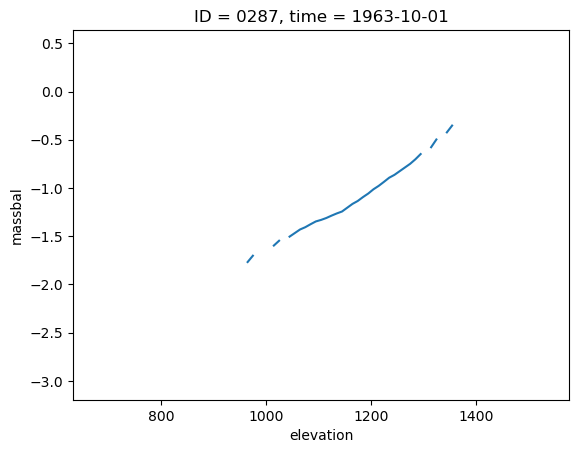

In [180]:
ds_summer_mb_elevband[0,2,:].plot()#(cmap='Reds')

## Combine annual and seasonal elevation-band mb in dataset

In [189]:
ds_mb_elev_band = xr.Dataset({
    'mb_annual': ds_annual_mb_elevband,  
    'mb_winter': ds_winter_mb_elevband,  
    'mb_summer': ds_summer_mb_elevband
})

ds_mb_elev_band.attrs['Model'] = 'PyGEM'


In [190]:
ds_mb_elev_band

<xarray.Dataset>
Dimensions:    (elevation: 226, time: 62, ID: 32)
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Model:    PyGEM

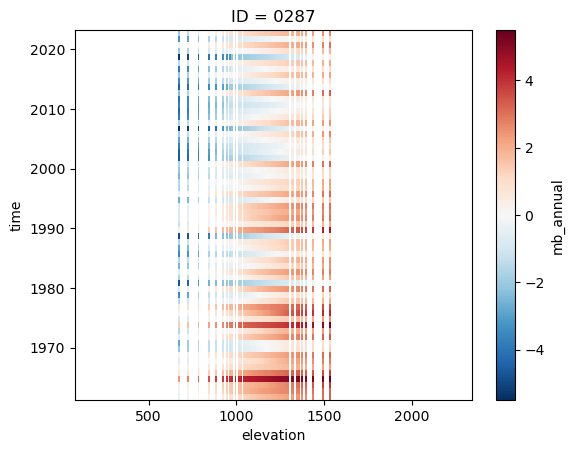

In [191]:
ds_mb_elev_band.mb_annual[0,:,:].plot()

In [192]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_mb_elev_band.to_netcdf(filepath_save + 'PyGEM_annual_seasonal_mb_elev_band.nc')